<a href="https://colab.research.google.com/github/sachaRfd/Chemistry-Related-notebooks/blob/main/Compound_Generation_with_Transformer_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code Adapted from the following Blog: 
https://www.cheminformania.com/non-conditional-de-novo-molecular-generation-with-transformer-encoders/

In [1]:
%load_ext tensorboard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.version

from google.colab import drive
drive.mount('/content/drive')

'3.8.16 (default, Dec  7 2022, 01:12:13) \n[GCC 7.5.0]'

In [2]:
!pip install kora -q
import kora.install.rdkit

     |████████████████████████████████| 57 kB 5.0 MB/s 
     |████████████████████████████████| 1.6 MB 37.0 MB/s 


In [3]:
!pip install rdkit -q

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors

     |████████████████████████████████| 29.3 MB 2.2 MB/s 


In [4]:
!pip -q install pytorch-lightning
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import LightningDataModule, LightningModule
# Set Device to GPU is available - otherwise set to CPU: 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Your Current Device is {device}')  # Check the Colab Device we are using

     |████████████████████████████████| 800 kB 14.3 MB/s 
     |████████████████████████████████| 512 kB 69.7 MB/s 
     |████████████████████████████████| 125 kB 73.7 MB/s 
Your Current Device is cuda


Simple character based tokeniser: 

In [5]:
# A simple tokenizer
class SimpleTokenizer():
  def __init__(self):
    self.start = "^"
    self.end = "$"
    self.unknown = "?"
    self.pad = " "
  def create_vocabulary(self, smiles):
    charset = set("".join(list(smiles)))
    #Important that pad gets value 0
    self.tokenlist = [self.pad, self.unknown, self.start, self.end] + list(charset)
  @property
  def tokenlist(self):
    return self._tokenlist
  @tokenlist.setter
  def tokenlist(self, tokenlist):
    self._tokenlist = tokenlist
    #create the dictionaries      
    self.char_to_int = {c:i for i,c in enumerate(self._tokenlist)}
    self.int_to_char = {i:c for c,i in self.char_to_int.items()}
  def vectorize(self, smiles):
      return [self.char_to_int[self.start]] + [self.char_to_int.get(char, self.char_to_int[self.unknown]) for char in smiles] + [self.char_to_int[self.end]]
  def devectorize(self, tensor):
      return [self.int_to_char[i] for i in tensor]
  @property
  def n_tokens(self):
    return len(self.int_to_char)

Dataset customisation that implements the Tokeniser: 

In [6]:
# Build a dataset, that returns tensors
class MolDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data
    self.tokenizer = tokenizer
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    smiles = self.data.smiles.iloc[idx]
    tensor = self.tokenizer.vectorize(smiles)
    return tensor

In [7]:
class ZincShardDataModule(LightningDataModule):
    def __init__(self):
        super().__init__()
        self.tokenizer = SimpleTokenizer()
        self.val_size = 200
        self.train_size = 200000
        self.batch_size = 128
        self.shard = "EEBD" #Shard must be > self.val_size + self.train_size
    def prepare_data(self):
        # called only on 1 GPU, no assignments of state!
        #e.g. use to download_dataset(), tokenize(), build_vocab()
        os.system(f"mkdir -pv {self.shard[0:2]} && wget -c http://files.docking.org/2D/{self.shard[0:2]}/{self.shard}.smi -O {self.shard[0:2]}/{self.shard}.smi")
    def randomize_smiles_atom_order(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        atom_idxs = list(range(mol.GetNumAtoms()))
        np.random.shuffle(atom_idxs)
        mol = Chem.RenumberAtoms(mol,atom_idxs)
        return Chem.MolToSmiles(mol, canonical=False)
    def custom_collate_and_pad(self, batch):
        #Batch is a list of vectorized smiles
        tensors = [torch.tensor(l) for l in batch]
        #pad and transpose, pytorch RNNs  (and now transformers) expect (sequence,batch, features) batch) dimensions
        tensors = torch.nn.utils.rnn.pad_sequence(tensors)
        return tensors
    def setup(self, stage=None):
        #Load data
        self.data = pd.read_csv(f"{self.shard[0:2]}/{self.shard}.smi", sep = " ", nrows = self.val_size + self.train_size)
        #Atom order randomize SMILES
        self.data["smiles"] = self.data["smiles"].apply(self.randomize_smiles_atom_order)
         
        #Initialize Tokenizer
        self.tokenizer.create_vocabulary(self.data.smiles.values)
        #Create splits for train/val
        np.random.seed(seed=42)
        idxs = np.array(range(len(self.data)))
        np.random.shuffle(idxs)
        val_idxs, train_idxs = idxs[:self.val_size], idxs[self.val_size:self.val_size+self.train_size]
        self.train_data = self.data.iloc[train_idxs]
        self.val_data = self.data.iloc[val_idxs]
    def train_dataloader(self):
        dataset = MolDataset(self.train_data, self.tokenizer)
        return DataLoader(dataset, batch_size=self.batch_size, pin_memory=True,collate_fn=self.custom_collate_and_pad)
    def val_dataloader(self):
        dataset = MolDataset(self.val_data, self.tokenizer)
        return DataLoader(dataset, batch_size=self.batch_size, pin_memory=True,collate_fn=self.custom_collate_and_pad, shuffle=False)


In [8]:
mydm = ZincShardDataModule()
mydm.prepare_data()
mydm.setup()

In [9]:
mydm.data.head()

,smiles,zinc_id
0,C(C(OCc1ccc2c(c1)OCO2)=O)Oc1ccccc1[N+](=O)[O-],6119166
1,c1c(NCCC(=O)N(C)CCc2ccccn2)c([N+]([O-])=O)ccc1,55206436
2,n1coc(C)c1C(OCC1CCN(c2ccc([N+]([O-])=O)cn2)CC1)=O,105766284
3,c1ccc([C@H](C)N2C(=S)N[C@@H](CCSC)C2=O)cc1[N+]...,55179745
4,[O-][N+](c1cc(NC(=O)CN2CCC(NC(C)C)CC2)c(C)cc1)=O,108371623


In [10]:
dl = mydm.val_dataloader()
test_batch = next(iter(dl))
test_batch

tensor([[ 2,  2,  2,  ...,  2,  2,  2],
        [10, 10, 10,  ..., 12,  8, 24],
        [19, 19, 19,  ..., 19, 19, 19],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]])

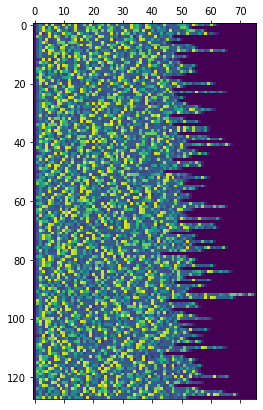

In [11]:
plt.matshow(test_batch.T)

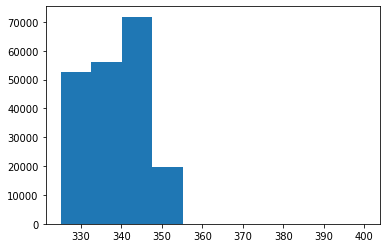

In [12]:
PandasTools.AddMoleculeColumnToFrame(mydm.data,'smiles','ROMol')
mydm.data["MW"] = mydm.data.ROMol.apply(Descriptors.MolWt)
_ = plt.hist(mydm.data["MW"])

Import of Positional Encoding: 
- So that the model understands the locations of the atoms: 

In [13]:
!wget -c https://raw.githubusercontent.com/pytorch/examples/master/word_language_model/model.py
from model import PositionalEncoding

--2023-01-01 22:18:27--  https://raw.githubusercontent.com/pytorch/examples/master/word_language_model/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6425 (6.3K) [text/plain]
Saving to: ‘model.py’

model.py            100%[===================>]   6.27K  --.-KB/s    in 0s      

2023-01-01 22:18:27 (57.4 MB/s) - ‘model.py’ saved [6425/6425]



In [14]:
# len(mydm.train_dataloader())

In [15]:
class SmilesEncoderModel(LightningModule):
    def __init__(
        self,
        n_tokens,
        d_model=256,
        nhead=8,
        num_encoder_layers=1,  # was 4
        dim_feedforward=1024,
        dropout=0.1,
        activation="relu",
        max_length = 1000,
        max_lr = 1e-3,
        epochs = 2,  #  was 50
    ):
        super().__init__()
        self.save_hyperparameters() #Populates self.hparams from __init__ options.
        self.setup_layers()
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.hparams.max_lr, 
                       total_steps=None, epochs=self.hparams.epochs, steps_per_epoch=782, # Supposed to be 782#We call train_dataloader, just to get the length, is this necessary?
                       pct_start=6/self.hparams.epochs, anneal_strategy='cos', cycle_momentum=True, 
                       base_momentum=0.85, max_momentum=0.95,
                       div_factor=1e3, final_div_factor=1e3, last_epoch=-1)
        scheduler = {"scheduler": scheduler, "interval" : "step" }
        return [optimizer], [scheduler]
    def setup_layers(self):
        self.embedding = torch.nn.Embedding(self.hparams.n_tokens, self.hparams.d_model)
        self.positional_encoder = PositionalEncoding(self.hparams.d_model, dropout=self.hparams.dropout)
        encoder_layer = torch.nn.TransformerEncoderLayer(self.hparams.d_model, self.hparams.nhead, self.hparams.dim_feedforward, self.hparams.dropout, self.hparams.activation)
        encoder_norm = torch.nn.LayerNorm(self.hparams.d_model)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, self.hparams.num_encoder_layers, encoder_norm)
        self.fc_out = torch.nn.Linear(self.hparams.d_model, self.hparams.n_tokens)
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    def forward(self, features):
        mask = self._generate_square_subsequent_mask(features.shape[0]).to(self.device)
        embedded = self.embedding(features)
        positional_encoded = self.positional_encoder(embedded)
        encoded = self.encoder(positional_encoded, mask=mask)
        out_2= self.fc_out(encoded)
        return out_2
    def step(self, batch):
        batch = batch.to(self.device)
        prediction = self.forward(batch[:-1])#Skipping the last character
        loss = torch.nn.functional.cross_entropy(prediction.transpose(0,1).transpose(1,2), batch[1:].transpose(0,1))#Skipping the first char
        return loss
    def training_step(self, batch, batch_idx):
        self.train()
        loss = self.step(batch)
        self.log('loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    def validation_step(self, batch, batch_idx):
        self.eval()
        loss = self.step(batch)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

In [16]:
mydm.batch_size = 512
model = SmilesEncoderModel(n_tokens=mydm.tokenizer.n_tokens, num_encoder_layers=4, d_model=512, nhead=8, epochs=25, max_lr=8e-4)

# Check it works as intended: 
out = model.forward(test_batch)
out.size()

torch.Size([76, 128, 37])

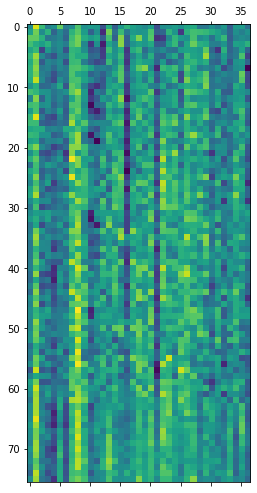

In [17]:
plt.matshow(out[:,0,:].detach())

In [20]:
import pytorch_lightning
lr_logger =pytorch_lightning.callbacks.lr_monitor.LearningRateMonitor(logging_interval="epoch")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger('tensorboard_logs/')
trainer = pytorch_lightning.Trainer(logger=tb_logger, 
    callbacks=[lr_logger], 
    max_epochs=model.hparams.epochs, accelerator='gpu',devices=1 
                    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
%tensorboard --logdir tensorboard_logs

In [21]:
trainer.fit(model, datamodule= mydm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | embedding          | Embedding          | 18.9 K
1 | positional_encoder | PositionalEncoding | 0     
2 | encoder            | TransformerEncoder | 8.4 M 
3 | fc_out             | Linear             | 19.0 K
----------------------------------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total params
33.800    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Save the model Parameters: 


In [23]:
import pickle
save_dict = {"state_dict": model.state_dict(), "tokenlist": mydm.tokenizer.tokenlist, "hparams":model.hparams}
!mkdir "drive/MyDrive/temp/deNovoFormer_25.pickle"  #  Check if this works
pickle.dump(save_dict, open("drive/MyDrive/temp/deNovoFormer_25.pickle","wb"))  # Find a way to fix this

FileNotFoundError: ignored

Sampling Model: 

In [25]:
model.eval()
out = model.forward(test_batch.to(device))
plt.matshow(out[:,7,:].to(device).detach())

TypeError: ignored

In [26]:
class Sampler():
  def __init__(self, model, tokenizer):
    self.model = model
    self.tokenizer = tokenizer
    self.max_len = 128
  def sample(self):
    model.eval()
    sample_tensor = torch.zeros((self.max_len,1), dtype=torch.long).to(model.device)
    sample_tensor[0,0] = self.tokenizer.char_to_int[self.tokenizer.start]
    with torch.no_grad():
      for i in range(self.max_len-1):
        tensor = sample_tensor[:i+1]
        logits = self.model.forward(tensor)[-1]
        probabilities = torch.nn.functional.softmax(logits, dim=1).squeeze()
        sampled_char = torch.multinomial(probabilities,1)
        sample_tensor[i+1,0] = sampled_char
        if sampled_char == self.tokenizer.char_to_int[self.tokenizer.end]:
          #print("Done")
          break
    smiles = "".join(self.tokenizer.devectorize(sample_tensor.squeeze().detach().cpu().numpy())).strip("^$ ")
    return smiles
  def sample_multi(self, n):
    smiles_list = []
    for i in range(n):
      smiles_list.append(self.sample())
    return smiles_list

In [27]:
model.to("cuda")
model.device

device(type='cuda', index=0)

In [40]:
sampler = Sampler(model, mydm.tokenizer)
smiles_list = sampler.sample_multi(200)

parsed_mols = np.array([Chem.MolFromSmiles(s) for s in smiles_list])

In [41]:
print("Percentage invalid")
(parsed_mols == None).sum()/len(parsed_mols)


Percentage invalid


0.905

In [42]:
parsed_mols

array([<rdkit.Chem.rdchem.Mol object at 0x7fafe837e970>, None, None,
       <rdkit.Chem.rdchem.Mol object at 0x7fafe837e9e0>, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None,
       <rdkit.Chem.rdchem.Mol object at 0x7fafe837eac0>, None,
       <rdkit.Chem.rdchem.Mol object at 0x7fafe837eb30>, None,
       <rdkit.Chem.rdchem.Mol object at 0x7fafe8465b30>, None, None, None,
       None, <rdkit.Chem.rdchem.Mol object at 0x7fafe8465510>, None, None,
       None, None, None, None, None, None, None,
       <rdkit.Chem.rdchem.Mol object at 0x7fafe8465820>, None, None, None,
       None, <rdkit.Chem.rdchem.Mol object at 0x7fafe8465970>, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, <rdkit.Chem.rdchem.Mol object at 0x7fafe84652e0>,
       None, None, None, None, None, None,
       <rdkit.Chem.rdchem.Mol object at 0x7fafe84656d0>, None, None, None,
       <rdk

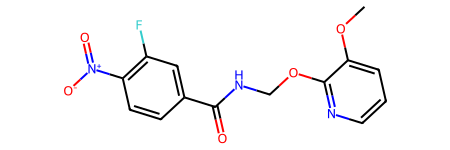

In [44]:
parsed_mols[0]

KeyError: ignored

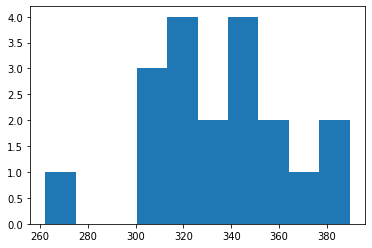

In [45]:
_ = plt.hist(list(map(Descriptors.MolWt, parsed_mols[parsed_mols != None])))
plt.axvline(x=min(mydm.data["MW"]), c="r")
plt.axvline(x=max(mydm.data["MW"]), c="r")